In [75]:
import os
import re
from keras.preprocessing.text import Tokenizer
import csv

def get_texts_from_file(path_corpus, path_truth):
    tr_txt = []
    tr_y = []
    with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
        for twitt in f_corpus:
            tr_txt += [twitt.strip()]
        for label in f_truth:
            tr_y += [label.strip()]        
    return tr_txt, tr_y

In [76]:
tr_txt, tr_y = get_texts_from_file("./agre/mex20_train.txt", "./agre/mex20_train_labels.txt")
val_txt, val_y = get_texts_from_file("./agre/mex20_val.txt", "./agre/mex20_val_labels.txt")

In [77]:
len(tr_y)

5278

In [78]:
tr_y = list(map(int, tr_y))
val_y = list(map(int, val_y))

Counter({0: 3759, 1: 1519})


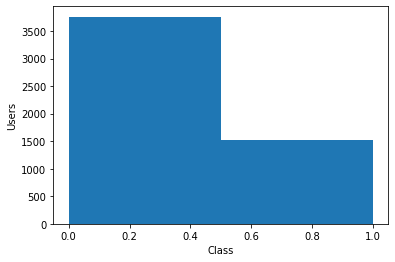

In [79]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_y))
plt.hist(tr_y, bins=len(set(tr_y)))
plt.ylabel('Users');
plt.xlabel('Class');

In [80]:
tr_txt[:50]

['@USUARIO @USUARIO @USUARIO Q se puede esperar del maricon de closet de la Yañez aun recuerdo esa ves q lo vi en zona rosa viendo quien lo levantada',
 '@USUARIO La piel nueva siempre arde un poquito los primeros días... y más con este puto clima',
 'Ustedes no se enamoran de mí… por tontas.',
 'Me las va a pagar esa puta gorda roba tuits...',
 '@USUARIO LA GENTE ES TONTA PORQUE NO SE DAN CUENTA QUE TÚ HACES A BATMAN AZUL',
 'Estoy muy encabronada con las pseudo feministas por tontas e iletradas, a veces me avergüenza ser mujer; preferiría tener un falo. #NiUnaMas',
 'Anden putos, recuerdan el #noerapenal #Holanda fuera de #Rusia2018, esto se llama #karma ehhhhhhhh #puuuuuutos',
 'Si no tienen chichis no traten de enseñar se ven muy mal y más cuando son prietas.',
 'Ojalá asi me agarrars cuando te digo que me voy en lugar de correrme a la verga cada 5 minutos.',
 '@USUARIO @USUARIO @USUARIO @USUARIO Es solo un HDP aprovechado y que su "Diosito Bimbo" me perdone',
 'La próxima vez que 

In [81]:
from nltk import RegexpTokenizer
from nltk import TweetTokenizer
import re

def tok(doc):
    #tokenizer = RegexpTokenizer('(?u)\b\w\w+\b')
    #c = re.compile(r'(?u)\b\w\w+\b')
    #return c.findall(doc)
    tokenizer = TweetTokenizer()
    return tokenizer.tokenize(doc)
    
print(tr_txt[8])
print(tok(tr_txt[8]))

Ojalá asi me agarrars cuando te digo que me voy en lugar de correrme a la verga cada 5 minutos.
['Ojalá', 'asi', 'me', 'agarrars', 'cuando', 'te', 'digo', 'que', 'me', 'voy', 'en', 'lugar', 'de', 'correrme', 'a', 'la', 'verga', 'cada', '5', 'minutos', '.']


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
import scipy.sparse as sp
from time import time
import numpy as np

def normalize(f):
    #f = [x.lower() for x in f]
    #f = [x.replace("\\n"," ") for x in f]        
    #f = [x.replace("\\t"," ") for x in f]        
    #f = [x.replace("\\xa0"," ") for x in f]
    #f = [x.replace("\\xc2"," ") for x in f]
    
    #f = [re.subn(" [*$%&#@][*$%&#@]+"," xexp ", x)[0].strip() for x in f]
    #f = [re.subn(" [0-9]+ "," DD ", x)[0].strip() for x in f]
    #f = [re.subn("<\S*>","", x)[0].strip() for x in f]
    return f

def ngrams(data, labels, ntrain, mn=1, mx=1, nm=500, binary = False, donorm = False, stopwords = False, verbose = True, analyzer_char = False):
    f = data
    if donorm:
        f = normalize(f)
    
    ftrain = f[:ntrain]
    ftest  = f[ntrain:]
    y_train = labels[:ntrain]
    
    t0 = time()
    analyzer_type = 'word'
    if analyzer_char:
        analyzer_type = 'char'
        
    if binary:
        vectorizer = CountVectorizer(max_n=mx,min_n=mn,binary=True)
    elif stopwords:
        vectorizer = TfidfVectorizer(max_n=mx,min_n=mn,stop_words='english',analyzer=analyzer_type,sublinear_tf=True)
    else:
        vectorizer = TfidfVectorizer(ngram_range=(mn,mx),sublinear_tf=True,analyzer=analyzer_type,lowercase=True)

    if verbose:
        print("extracting ngrams... where n is [%d,%d]" % (mn,mx))
    
    X_train = vectorizer.fit_transform(ftrain)
    X_test = vectorizer.transform(ftest)
    #print(ftrain[:10])
    
    if verbose:
        print("done in %fs" % (time() - t0), X_train.shape, X_test.shape)

    y = np.array(y_train)    
    
    numFts = nm
    if numFts < X_train.shape[1]:
        t0 = time()
        ch2 = SelectKBest(chi2, k=numFts)
        X_train = ch2.fit_transform(X_train, y)
        X_test = ch2.transform(X_test)
        assert sp.issparse(X_train)        

    if verbose:
        print("Extracting best features by a chi-squared test.. ", X_train.shape, X_test.shape)
    return X_train, y, X_test

In [83]:
train = tr_txt
test = val_txt
labels = tr_y

data = train + test
n = len(data)
ntrain = len(train)

verbose = True

t0 = time()

X_train1, y_train, X_test1 = ngrams(data, labels, ntrain, 1, 1, 5000, donorm = True, verbose = verbose)
X_train2, y_train, X_test2 = ngrams(data, labels, ntrain, 2, 2, 2000, donorm = True, verbose = verbose)
X_train3, y_train, X_test3 = ngrams(data, labels, ntrain, 3, 3, 1000,  donorm = True, verbose = verbose)
X_train4, y_train, X_test4 = ngrams(data, labels, ntrain, 4, 4, 3000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train5, y_train, X_test5 = ngrams(data, labels, ntrain, 5, 5, 5000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train6, y_train, X_test6 = ngrams(data, labels, ntrain, 3, 3, 2000, donorm = True, verbose = verbose, analyzer_char = True)

from sklearn import metrics, preprocessing

#from numpy import genfromtxt
#ft_tr = genfromtxt('tr.w', delimiter=' ')
#ft_tr2=preprocessing.normalize(ft_tr, norm='l1')

#from numpy import genfromtxt
#ft_te = genfromtxt('te.w', delimiter=' ')
#ft_te2=preprocessing.normalize(ft_te, norm='l1')

TRAIN = sp.hstack([X_train1, X_train2, X_train3, X_train4, X_train5, X_train6])#, ft_tr2])
TEST = sp.hstack([X_test1,  X_test2,  X_test3, X_test4, X_test5, X_test6])#, ft_te2])

#TR_DDR = preprocessing.normalize(TR_DDR, norm='l1')
#TE_DDR = preprocessing.normalize(TE_DDR, norm='l1')

#TR_DDR = ft_tr2
#TE_DDR = ft_te2
if verbose:
    print("######## Total time for feature extraction: %fs" % (time() - t0), TR_DDR.shape, TE_DDR.shape)

extracting ngrams... where n is [1,1]
done in 0.106960s (5278, 12487) (587, 12487)
Extracting best features by a chi-squared test..  (5278, 5000) (587, 5000)
extracting ngrams... where n is [2,2]
done in 0.205589s (5278, 46062) (587, 46062)
Extracting best features by a chi-squared test..  (5278, 2000) (587, 2000)
extracting ngrams... where n is [3,3]
done in 0.204229s (5278, 62730) (587, 62730)
Extracting best features by a chi-squared test..  (5278, 1000) (587, 1000)
extracting ngrams... where n is [4,4]
done in 0.309832s (5278, 40150) (587, 40150)
Extracting best features by a chi-squared test..  (5278, 3000) (587, 3000)
extracting ngrams... where n is [5,5]
done in 0.428046s (5278, 86102) (587, 86102)
Extracting best features by a chi-squared test..  (5278, 5000) (587, 5000)
extracting ngrams... where n is [3,3]
done in 0.259565s (5278, 13409) (587, 13409)
Extracting best features by a chi-squared test..  (5278, 2000) (587, 2000)
######## Total time for feature extraction: 1.738507

In [84]:
TRAIN.shape

(5278, 18000)

In [85]:
TEST.shape

(587, 18000)

In [86]:
import csv
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
import numpy as np

from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
    
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=7)

grid.fit(TRAIN, labels) 

y_pred = grid.predict(TEST)

p, r, f, _ = precision_recall_fscore_support(val_y, y_pred, average='macro', pos_label=None)

print(confusion_matrix(val_y, y_pred))
print(metrics.classification_report(val_y, y_pred))

[[382  36]
 [ 47 122]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       418
           1       0.77      0.72      0.75       169

    accuracy                           0.86       587
   macro avg       0.83      0.82      0.82       587
weighted avg       0.86      0.86      0.86       587



# Entrenando con TODO

In [87]:
test_txt, _ = get_texts_from_file("./agre/mex20_test_full.txt", "./agre/mex20_val_labels.txt")

In [88]:
train = tr_txt + val_txt
test = test_txt
labels = tr_y + val_y

data = train + test
n = len(data)
ntrain = len(train)

verbose = True

t0 = time()

X_train1, y_train, X_test1 = ngrams(data, labels, ntrain, 1, 1, 5000, donorm = True, verbose = verbose)
X_train2, y_train, X_test2 = ngrams(data, labels, ntrain, 2, 2, 2000, donorm = True, verbose = verbose)
X_train3, y_train, X_test3 = ngrams(data, labels, ntrain, 3, 3, 1000,  donorm = True, verbose = verbose)
X_train4, y_train, X_test4 = ngrams(data, labels, ntrain, 4, 4, 3000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train5, y_train, X_test5 = ngrams(data, labels, ntrain, 5, 5, 5000, donorm = True, verbose = verbose, analyzer_char = True)    
X_train6, y_train, X_test6 = ngrams(data, labels, ntrain, 3, 3, 2000, donorm = True, verbose = verbose, analyzer_char = True)

from sklearn import metrics, preprocessing

#from numpy import genfromtxt
#ft_tr = genfromtxt('tr.w', delimiter=' ')
#ft_tr2=preprocessing.normalize(ft_tr, norm='l1')

#from numpy import genfromtxt
#ft_te = genfromtxt('te.w', delimiter=' ')
#ft_te2=preprocessing.normalize(ft_te, norm='l1')

TRAIN = sp.hstack([X_train1, X_train2, X_train3, X_train4, X_train5, X_train6])#, ft_tr2])
TEST = sp.hstack([X_test1,  X_test2,  X_test3, X_test4, X_test5, X_test6])#, ft_te2])

#TR_DDR = preprocessing.normalize(TR_DDR, norm='l1')
#TE_DDR = preprocessing.normalize(TE_DDR, norm='l1')

#TR_DDR = ft_tr2
#TE_DDR = ft_te2
if verbose:
    print("######## Total time for feature extraction: %fs" % (time() - t0), TR_DDR.shape, TE_DDR.shape)

extracting ngrams... where n is [1,1]
done in 0.111576s (5865, 13371) (1467, 13371)
Extracting best features by a chi-squared test..  (5865, 5000) (1467, 5000)
extracting ngrams... where n is [2,2]
done in 0.200366s (5865, 50293) (1467, 50293)
Extracting best features by a chi-squared test..  (5865, 2000) (1467, 2000)
extracting ngrams... where n is [3,3]
done in 0.234888s (5865, 69440) (1467, 69440)
Extracting best features by a chi-squared test..  (5865, 1000) (1467, 1000)
extracting ngrams... where n is [4,4]
done in 0.438125s (5865, 42253) (1467, 42253)
Extracting best features by a chi-squared test..  (5865, 3000) (1467, 3000)
extracting ngrams... where n is [5,5]
done in 0.498322s (5865, 91279) (1467, 91279)
Extracting best features by a chi-squared test..  (5865, 5000) (1467, 5000)
extracting ngrams... where n is [3,3]
done in 0.316037s (5865, 14043) (1467, 14043)
Extracting best features by a chi-squared test..  (5865, 2000) (1467, 2000)
######## Total time for feature extracti

In [89]:
TRAIN.shape

(5865, 18000)

In [90]:
len(labels)

5865

In [91]:
import csv
import argparse
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
from sklearn import metrics, preprocessing
import numpy as np

from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
    
parameters = {'C': [.05, .12, .25, .5, 1, 2, 4]}

svr = svm.LinearSVC(class_weight='balanced')
grid = GridSearchCV(estimator=svr, param_grid=parameters, n_jobs=8, scoring="f1_macro", cv=7)

grid.fit(TRAIN, labels) 

y_pred = grid.predict(TEST)

f = open("pastor.csv", "w")
f.write("Id,Expected\n")
for pred, n in zip(y_pred, range(len(y_pred))):
    f.write(str(n) + "," + str(pred) + "\n")
f.close()

#p, r, f, _ = precision_recall_fscore_support(val_y, y_pred, average='macro', pos_label=None)

#print(confusion_matrix(val_y, y_pred))
#print(metrics.classification_report(val_y, y_pred))